# Amazon Reviews Exploration 


<b>Author:</b> Przemyslaw Niedziela (przemyslaw.niedziela98@gmail.com) <br> 
<b>Date:</b> Nov 2024 <br>
<br> <br> 

TL;DR <br>
This notebook explores Amazon product reviews to uncover p|tterns and clusters using steos from EDA to PCA and clustering. High silhouette and low Davies-Bouldin scores indicate that reviews within clusters are similar but well-separated. 

<br> <br> 
Table of contents: 
1. [Initial Exploration](#initial-exploration)
2. [Preprocessing](#preprocessing)
3. [Calculating embeddings](#calculating-embeddings)
4. [PCA](#pca)
5. [Clustering](#clustering)

In [21]:
import re
import warnings

import hdbscan
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import umap

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

warnings.filterwarnings('ignore')


In [3]:
DATASET_PATH = "/Users/przemyslawniedziela/.cache/kagglehub/datasets/arhamrumi/amazon-product-reviews/versions/1/Reviews.csv"

CONTRACTIONS = {
    "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
    "'t": " not", "'ve": " have", "'m": " am"
}

### Initial Exploration 

In [4]:
dataset = pd.read_csv(DATASET_PATH, index_col = [0])

In [5]:
dataset.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568454 entries, 1 to 568454
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               568454 non-null  object
 1   UserId                  568454 non-null  object
 2   ProfileName             568428 non-null  object
 3   HelpfulnessNumerator    568454 non-null  int64 
 4   HelpfulnessDenominator  568454 non-null  int64 
 5   Score                   568454 non-null  int64 
 6   Time                    568454 non-null  int64 
 7   Summary                 568427 non-null  object
 8   Text                    568454 non-null  object
dtypes: int64(4), object(5)
memory usage: 43.4+ MB


In [7]:
dataset.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
print(f"""Nr of records: {dataset.shape[0]}
Nr of distinct products: {dataset['ProductId'].unique().shape[0]}
Nr of distinct users: {dataset['ProfileName'].unique().shape[0]}""")

Nr of records: 568454
Nr of distinct products: 74258
Nr of distinct users: 218416


### Preprocessing 

Expanding contractions, removing stopwords, lammatization - reducing noise for clustering. 

In [9]:
dataset = dataset.dropna() 
dataset_subset = dataset.sample(int(1e4))

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def expand_contractions(text):
    """Expand common contractions in text."""
    for contraction, expanded in CONTRACTIONS.items():
        text = re.sub(contraction, expanded, text)
    return text

def preprocess_text(text):
    """
    Preprocess the input text by cleaning, normalizing, and tokenizing.

    - Convert text to lowercase.
    - Expand contractions
    - Remove punctuation and special characters.
    - Remove numbers.
    - Remove stopwords.
    - Lemmatize the tokens to their base forms.
    """
    text = expand_contractions(text.lower())
    text = re.sub(r'[^a-z\s]', '', text)  
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]    
    return ' '.join(tokens)

dataset_subset['clean_text'] = dataset_subset['Text'].apply(preprocess_text)

### Calculating embeddings

Generating sentence embeddings to capture semantic meaning, converting reviews into high-dimensional vectors. 

In [12]:
model = SentenceTransformer('all-MiniLM-L6-v2')

batch_size = 1024  
review_embeddings = []

for start in range(0, len(dataset_subset), batch_size):
    print(f"Progress: {round(start/dataset_subset.shape[0] * 100, 2)}%")
    batch = dataset_subset['clean_text'].iloc[start:start + batch_size].tolist()
    batch_embeddings = model.encode(batch, show_progress_bar=True)
    review_embeddings.extend(batch_embeddings)

review_embeddings = np.array(review_embeddings)


Progress: 0.0%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Progress: 10.24%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Progress: 20.48%


Batches: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Progress: 30.72%


Batches: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Progress: 40.96%


Batches: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Progress: 51.2%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Progress: 61.44%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


Progress: 71.68%


Batches: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Progress: 81.92%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Progress: 92.16%


Batches: 100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


### PCA

Reducing embeddings' dimensionality and highlighting dominant themes 

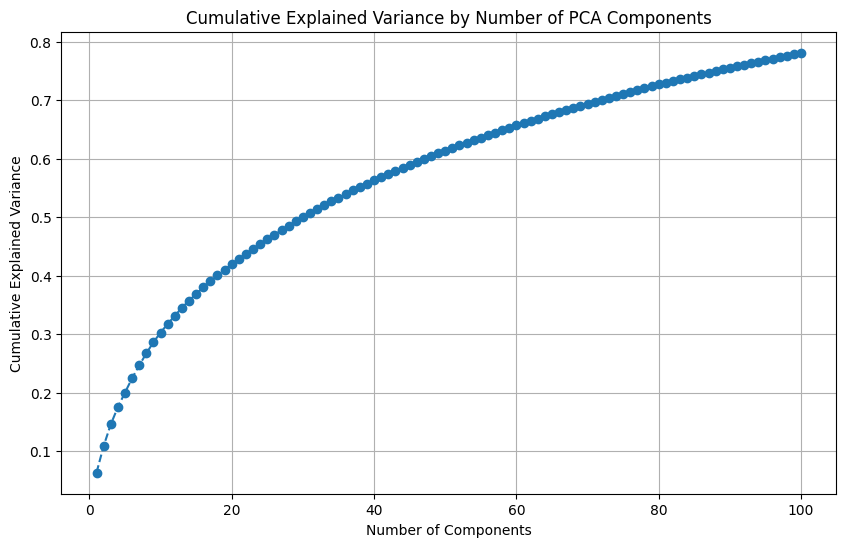

Explained variance by top components: [0.06313011 0.1086864  0.14565702 0.17523694 0.20009314 0.22464314
 0.24643312 0.2672214  0.28625792 0.3027694 ]


In [13]:
def perform_pca(embeddings, n_components=100):
    """
    Perform PCA on the embeddings and return the PCA model and transformed embeddings.
    - n_components: Number of PCA components to keep.
    """
    pca = PCA(n_components=n_components)
    pca_embeddings = pca.fit_transform(embeddings)
    
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), explained_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    print(f"Explained variance by top components: {explained_variance[:10]}")
    
    return pca, pca_embeddings

pca_model, pca_embeddings = perform_pca(review_embeddings, n_components=100)

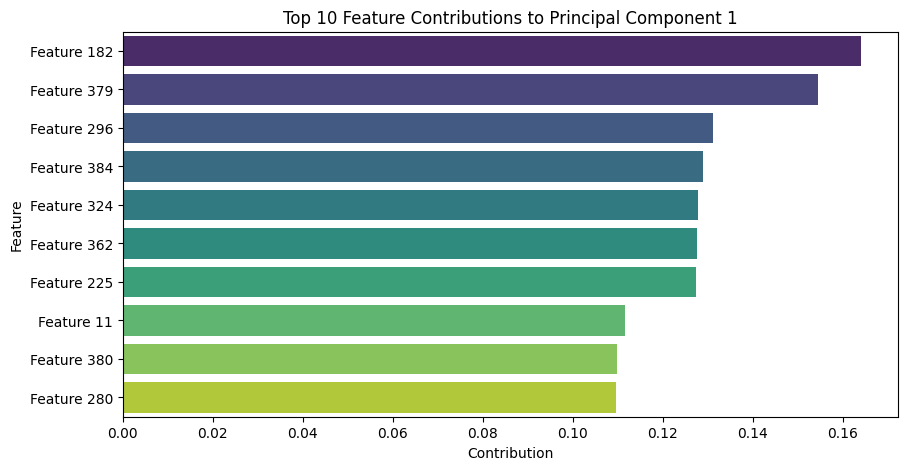

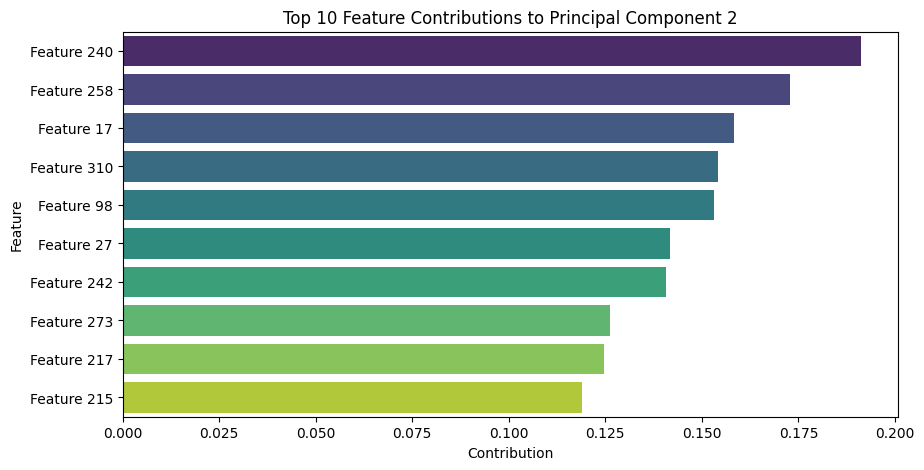

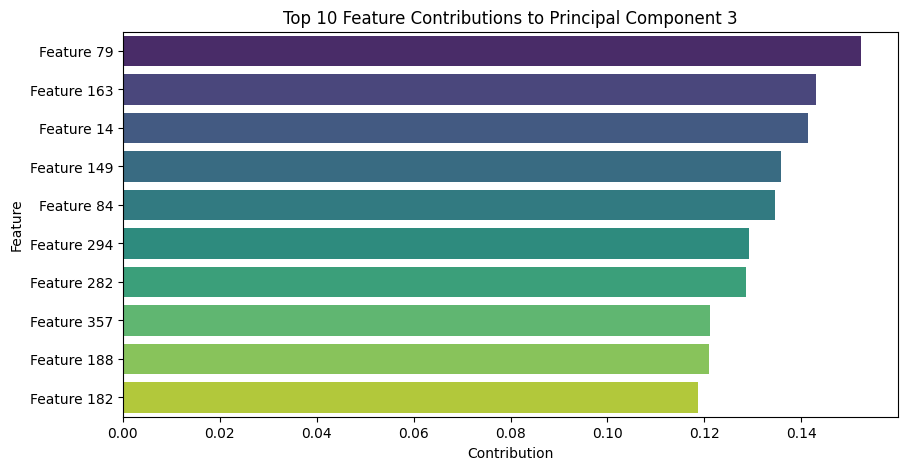

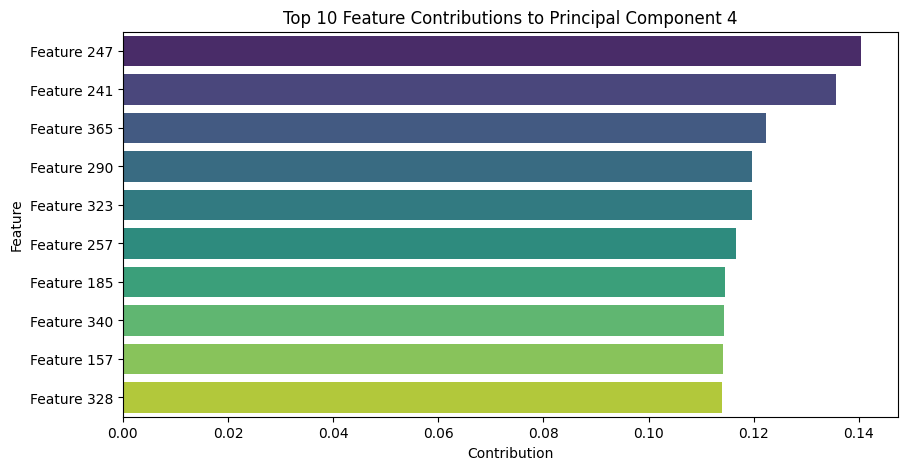

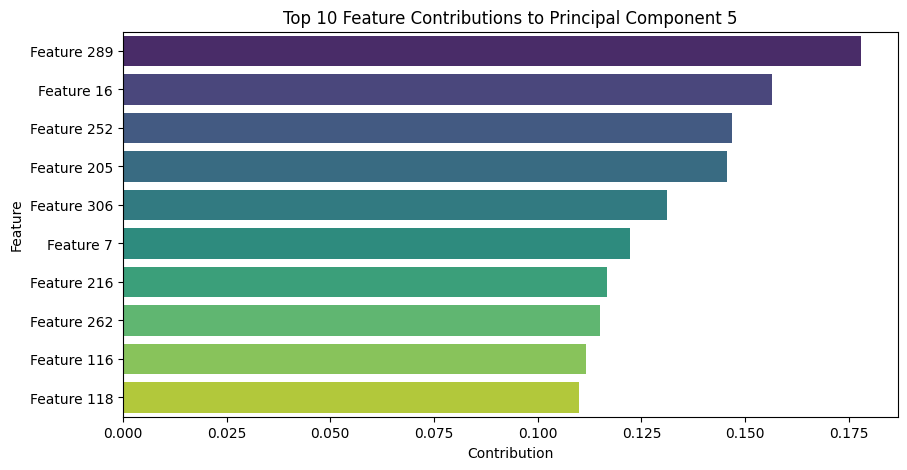

In [14]:
def plot_feature_contributions(pca, feature_names, top_n=10):
    """
    Plot the contributions of original features (words) to each principal component.
    - top_n: Number of top contributing features to display per component.
    """
    component_df = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(len(pca.components_))])

    for i in range(min(5, len(pca.components_))): 
        component = component_df.iloc[i]
        top_features = component.abs().sort_values(ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
        plt.title(f'Top {top_n} Feature Contributions to Principal Component {i+1}')
        plt.xlabel('Contribution')
        plt.ylabel('Feature')
        plt.show()

feature_names = [f'Feature {i+1}' for i in range(review_embeddings.shape[1])]
plot_feature_contributions(pca_model, feature_names, top_n=10)

### Clustering 
KMeans and HDBSCAN to reveal natural grouping of reviews. 

In [15]:
def reduce_dimensions(embeddings, pca_components=50, umap_components=2):
    """
    Reduce dimensionality with PCA followed by UMAP.
    - pca_components: Number of components to keep in initial PCA reduction.
    - umap_components: Final dimensionality reduction to 2D using UMAP.
    """
    pca = PCA(n_components=pca_components, random_state=42)
    pca_embeddings = pca.fit_transform(embeddings)
    
    umap_reducer = umap.UMAP(n_components=umap_components, random_state=42, metric='correlation')
    umap_embeddings = umap_reducer.fit_transform(pca_embeddings)
    
    return pca_embeddings, umap_embeddings

pca_embeddings, umap_embeddings = reduce_dimensions(review_embeddings, pca_components=50, umap_components=2)

In [16]:
def cluster_embeddings(embeddings, kmeans_clusters=10, min_cluster_size=20):
    """
    Perform clustering with KMeans and HDBSCAN, and evaluate using metrics.
    - kmeans_clusters: Number of clusters for KMeans.
    - min_cluster_size: Minimum size of clusters for HDBSCAN.
    """
    kmeans = KMeans(n_clusters=kmeans_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(embeddings)
    
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean')
    hdbscan_labels = hdbscan_clusterer.fit_predict(embeddings)
    
    kmeans_silhouette = silhouette_score(embeddings, kmeans_labels)
    kmeans_davies_bouldin = davies_bouldin_score(embeddings, kmeans_labels)
    
    hdbscan_silhouette = silhouette_score(embeddings, hdbscan_labels) if len(set(hdbscan_labels)) > 1 else None
    hdbscan_davies_bouldin = davies_bouldin_score(embeddings, hdbscan_labels) if len(set(hdbscan_labels)) > 1 else None
    
    print(f"KMeans Silhouette Score: {kmeans_silhouette:.3f}")
    print(f"KMeans Davies-Bouldin Index: {kmeans_davies_bouldin:.3f}")
    
    if hdbscan_silhouette:
        print(f"HDBSCAN Silhouette Score: {hdbscan_silhouette:.3f}")
    if hdbscan_davies_bouldin:
        print(f"HDBSCAN Davies-Bouldin Indegit rebase -i HEAD~nx: {hdbscan_davies_bouldin:.3f}")
    
    return kmeans_labels, hdbscan_labels

kmeans_labels, hdbscan_labels = cluster_embeddings(pca_embeddings, kmeans_clusters=10, min_cluster_size=20)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KMeans Silhouette Score: 0.066
KMeans Davies-Bouldin Index: 3.127
HDBSCAN Silhouette Score: -0.061
HDBSCAN Davies-Bouldin Index: 3.089


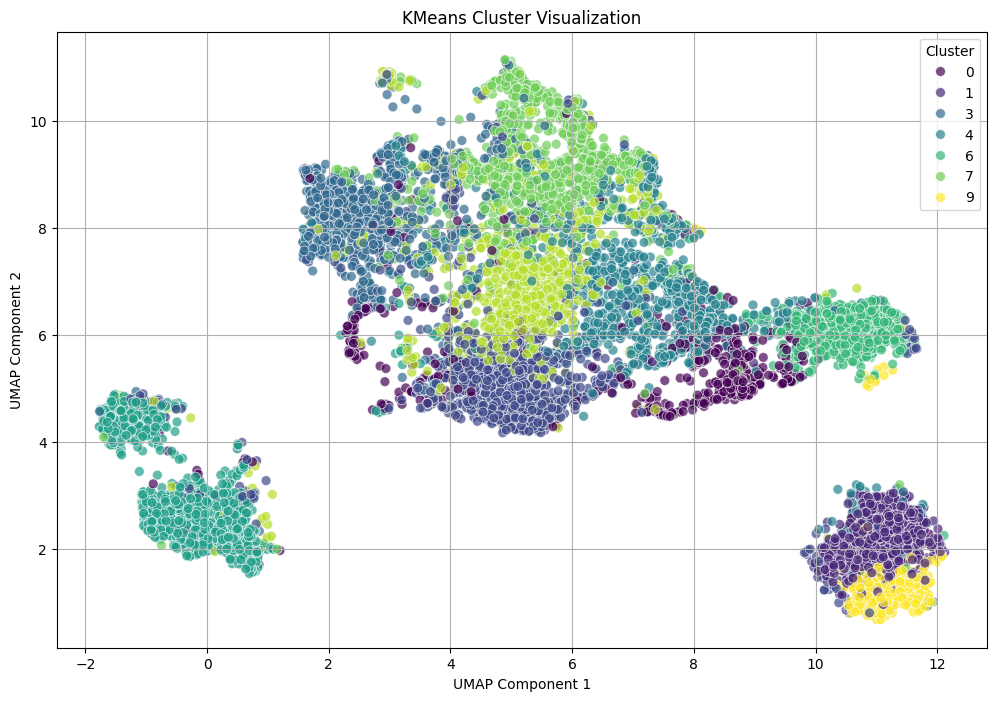

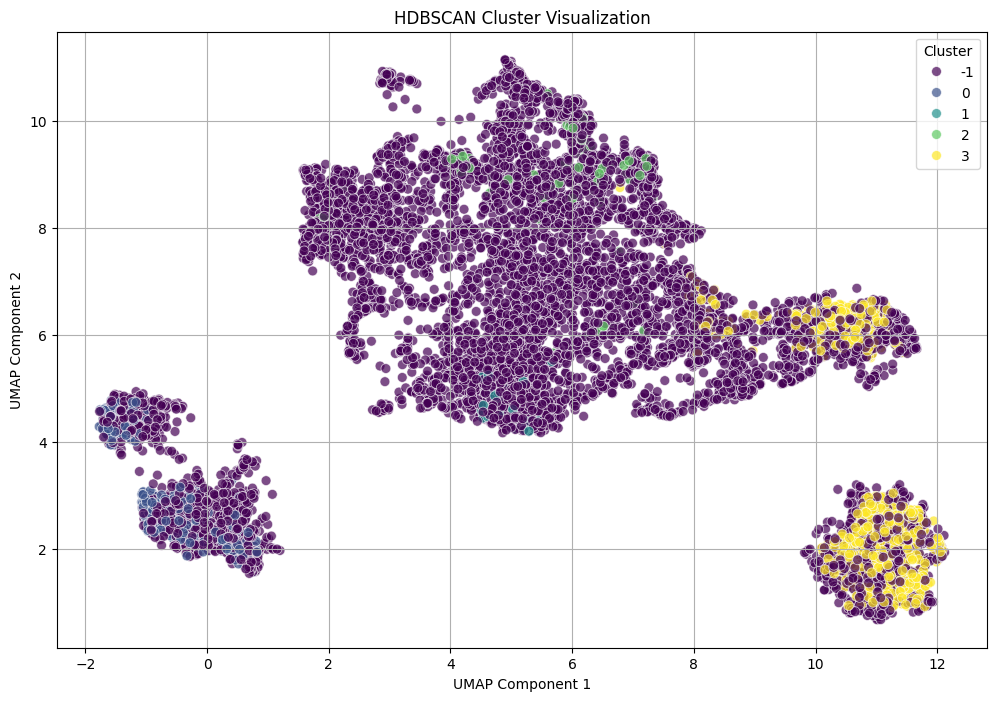

In [17]:
def plot_clusters(umap_embeddings, labels, title="Cluster Visualization"):
    """
    Plot clusters in 2D with different colors for each cluster.
    """
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=labels, palette='viridis', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend(title='Cluster', loc='best', bbox_to_anchor=(1, 1), ncol=1)
    plt.grid(True)
    plt.show()

plot_clusters(umap_embeddings, kmeans_labels, title="KMeans Cluster Visualization")
plot_clusters(umap_embeddings, hdbscan_labels, title="HDBSCAN Cluster Visualization")

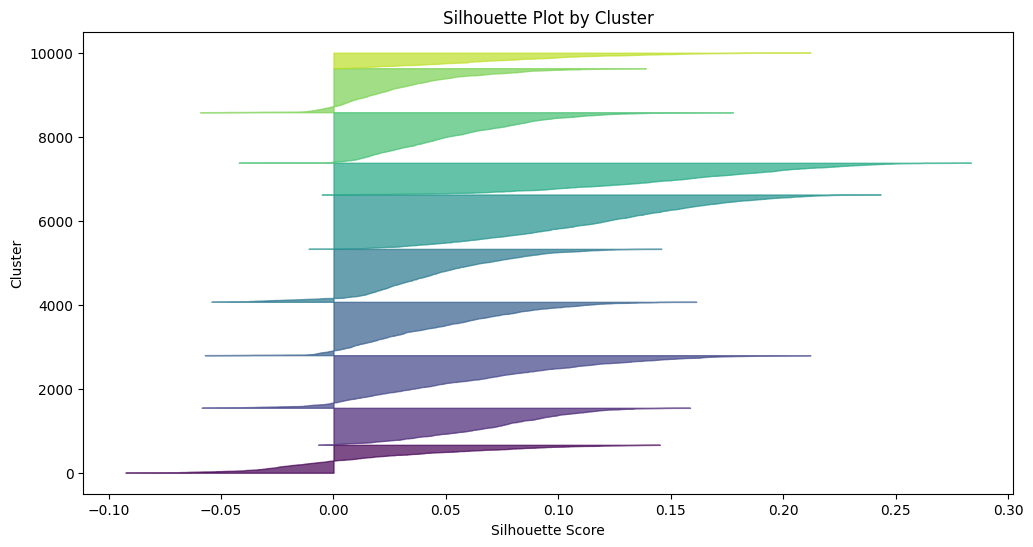

In [18]:
def analyze_cluster_distribution(embeddings, labels):
    """
    Analyze and plot silhouette scores for each sample and cluster sizes.
    """
    unique_labels = np.unique(labels)

    if len(embeddings.shape) == 1:
        embeddings = embeddings.reshape(-1, 1)

    silhouette_vals = silhouette_samples(embeddings, labels)
    
    plt.figure(figsize=(12, 6))
    y_lower, y_upper = 0, 0
    for i, label in enumerate(unique_labels):
        cluster_silhouette_vals = silhouette_vals[labels == label]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        color = plt.cm.viridis(float(i) / len(unique_labels))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        y_lower += len(cluster_silhouette_vals)

    plt.title("Silhouette Plot by Cluster")
    plt.xlabel("Silhouette Score")
    plt.ylabel("Cluster")
    plt.show()

analyze_cluster_distribution(pca_embeddings, kmeans_labels)

#### Cluster Distinctiveness

The ANOVA results support the distinctiveness of clusters in the principal component space.

In [20]:
pca_df = pd.DataFrame(pca_embeddings, columns=[f'PC{i+1}' for i in range(pca_embeddings.shape[1])])
pca_df['Cluster'] = kmeans_labels

anova_results = {}
for component in pca_df.columns[:-1]: 
    grouped_data = [pca_df[component][pca_df['Cluster'] == label] for label in np.unique(kmeans_labels)]
    anova_result = f_oneway(*grouped_data)
    anova_results[component] = {'F-statistic': anova_result.statistic, 'p-value': anova_result.pvalue}

for component, result in anova_results.items():
    print(f"{component} - F-statistic: {result['F-statistic']:.2f}, p-value: {result['p-value']:.5f}")

PC1 - F-statistic: 4339.42, p-value: 0.00000
PC2 - F-statistic: 1714.49, p-value: 0.00000
PC3 - F-statistic: 1718.11, p-value: 0.00000
PC4 - F-statistic: 1393.61, p-value: 0.00000
PC5 - F-statistic: 707.19, p-value: 0.00000
PC6 - F-statistic: 365.22, p-value: 0.00000
PC7 - F-statistic: 262.66, p-value: 0.00000
PC8 - F-statistic: 409.17, p-value: 0.00000
PC9 - F-statistic: 182.09, p-value: 0.00000
PC10 - F-statistic: 307.17, p-value: 0.00000
PC11 - F-statistic: 36.38, p-value: 0.00000
PC12 - F-statistic: 56.02, p-value: 0.00000
PC13 - F-statistic: 101.06, p-value: 0.00000
PC14 - F-statistic: 38.46, p-value: 0.00000
PC15 - F-statistic: 31.97, p-value: 0.00000
PC16 - F-statistic: 18.19, p-value: 0.00000
PC17 - F-statistic: 58.51, p-value: 0.00000
PC18 - F-statistic: 34.04, p-value: 0.00000
PC19 - F-statistic: 17.67, p-value: 0.00000
PC20 - F-statistic: 23.70, p-value: 0.00000
PC21 - F-statistic: 31.61, p-value: 0.00000
PC22 - F-statistic: 81.56, p-value: 0.00000
PC23 - F-statistic: 17.10,